# Solução do Desafio Codenation - Prever a nota de matemática do enem 2016

Como exercício e treinamento de meus estudos em Machine Learning desenvolvi o modelo preditivo a ser mostrado nesse notebook proposto pelo site de desafios Codenation. O modelo ainda está em testes e poderá ser aprimorado/atualizado.

Página oficial do desafio: https://www.codenation.com.br/journey/data-science/challenge/enem-2.html

## Introdução

O desafio consiste em estimar a nota de matemática referente ao enem 2016 através da leitura de dois datasets fornecidos nos arquivos _test.csv_ e _train.csv_. Para realizar esse desafio com suas devidas instruções e arquivos e obter a pontuação, basta acessar o link e seguir as instruções fornecidas pelo autor.

## Desenvolvimento

In [1]:
# Importar as bibliotecas a serem usadas
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Leitura dos datasets de treino e teste e criação do df de resposta
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')
df_resposta = pd.DataFrame()

### Análise Exploratória Simplificada

Para simplificar bem o processo, analisaremos somente quais as features mais importantes a serem utilizadas nesse modelo, pois esse dataset contém diversas colunas e somente os valores que influenciarem mais na nota serão relevantes:

In [3]:
# Verificar se os dados de teste estão nos dados de treinamento
print(set(df_test.columns).issubset(set(df_train.columns)))

True


In [4]:
df_test.describe()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,...,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,4576.000000,4576.000000,4576.000000,4576.000000,4576.000000,4576.000000,4576.000000,1480.000000,4576.000000,1480.000000,...,3442.000000,3377.000000,4576.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000,3377.000000
mean,30.762019,21.542395,2.181163,1.060970,1.791084,2.119537,1.368663,1.182432,0.127404,2.264865,...,529.195264,514.304205,0.604458,1.095943,119.626888,111.915902,106.384365,112.881256,76.683447,527.491857
std,9.912313,6.854073,1.017531,0.281289,0.875692,3.210353,0.568589,0.572495,0.333461,0.716922,...,73.086665,67.725564,0.489020,0.695047,29.028146,33.296849,33.834492,33.202244,42.985637,151.979490
min,11.000000,14.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,...,479.725000,468.400000,0.000000,1.000000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000
50%,31.000000,19.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.000000,...,532.000000,516.800000,1.000000,1.000000,120.000000,120.000000,100.000000,120.000000,80.000000,540.000000
75%,35.000000,23.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,0.000000,2.000000,...,579.550000,562.400000,1.000000,1.000000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000
max,53.000000,65.000000,5.000000,4.000000,4.000000,10.000000,3.000000,3.000000,1.000000,4.000000,...,773.600000,708.900000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,980.000000


Ok! Os dados foram validados, agora podemos salvar o número de inscrição que usaremos só no arquivo de resposta final:

In [5]:
# Salvar os dados das inscrições
df_resposta['NU_INSCRICAO'] = df_test['NU_INSCRICAO']
df_test.drop('NU_INSCRICAO', axis=1, inplace=True)

Selecionaremos para a regressão somente os valores numéricos

In [6]:
# Selecionar somente valores inteiros e floats
df_test = df_test.select_dtypes(include=['int64','float64'])

Agora vamos verificar qual a correlação de algumas das variáveis para decidir quais serão usadas no modelo:

In [7]:
var = ['NU_IDADE','TP_COR_RACA','IN_TREINEIRO','TP_NACIONALIDADE','CO_UF_RESIDENCIA','NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']
df_test[var].corr()

,NU_IDADE,TP_COR_RACA,IN_TREINEIRO,TP_NACIONALIDADE,CO_UF_RESIDENCIA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO
NU_IDADE,1.000000,0.006029,-0.293714,-0.004572,-0.027277,-0.105278,-0.048229,-0.079171,-0.161202
TP_COR_RACA,0.006029,1.000000,0.033100,0.027840,-0.223924,-0.159068,-0.161977,-0.158654,-0.117604
IN_TREINEIRO,-0.293714,0.033100,1.000000,0.012710,-0.046836,-0.009669,-0.032181,-0.004934,-0.014277
TP_NACIONALIDADE,-0.004572,0.027840,0.012710,1.000000,0.003637,-0.060391,-0.059370,-0.079824,-0.064910
CO_UF_RESIDENCIA,-0.027277,-0.223924,-0.046836,0.003637,1.000000,0.083600,0.135885,0.143118,0.084533
NU_NOTA_CN,-0.105278,-0.159068,-0.009669,-0.060391,0.083600,1.000000,0.598574,0.545801,0.442692
NU_NOTA_CH,-0.048229,-0.161977,-0.032181,-0.059370,0.135885,0.598574,1.000000,0.679993,0.537141
NU_NOTA_LC,-0.079171,-0.158654,-0.004934,-0.079824,0.143118,0.545801,0.679993,1.000000,0.495745
NU_NOTA_REDACAO,-0.161202,-0.117604,-0.014277,-0.064910,0.084533,0.442692,0.537141,0.495745,1.000000


Vamos usar nesse modelo as notas NU_NOTA_CN, NU_NOTA_CH, NU_NOTA_LC, NU_NOTA_REDACAO e o campo CO_UF_RESIDENCIA que possuem boa correlação.

In [8]:
features = ['CO_UF_RESIDENCIA','NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO', 'CO_UF_RESIDENCIA']

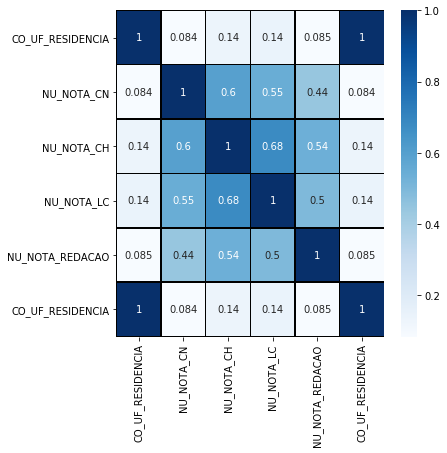

In [9]:
%matplotlib inline

plt.figure(figsize=(6,6))
sns.heatmap(df_test[features].corr(), annot=True, linewidths=0.5, linecolor='black', cmap='Blues')
plt.xticks(rotation=90)
plt.show()

### Validação e Tratamento dos dados

Na correlação das variáveis do dataset, pode-se observar que há registros em que todas as colunas se encontram vazias. Em registros nos quais todas as provas (NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO) tenham as notas como nulas, pode-se estimar que esse aluno não foi realizar as provas, portanto devemos remover essas linhas do dataset de treino:

In [10]:
# Usando o loc com uma condição composta para obter somente registros com todas as provas
df_train = df_train.loc[(df_train['NU_NOTA_CN'].notnull()) & (df_train['NU_NOTA_CH'].notnull())  & (df_train['NU_NOTA_LC'].notnull()) & (df_train['NU_NOTA_REDACAO'].notnull()) & (df_train['NU_NOTA_MT'].notnull())]

Após a remoção desses registros, percebe-se que há registros dos dataframes de teste com notas de algumas provas faltantes, o que não é bom para o modelo preditivo:

In [11]:
df_test[features].isnull().sum()

CO_UF_RESIDENCIA       0
NU_NOTA_CN          1134
NU_NOTA_CH          1134
NU_NOTA_LC          1199
NU_NOTA_REDACAO     1199
CO_UF_RESIDENCIA       0
dtype: int64

In [12]:
df_train[features].isnull().sum()

CO_UF_RESIDENCIA    0
NU_NOTA_CN          0
NU_NOTA_CH          0
NU_NOTA_LC          0
NU_NOTA_REDACAO     0
CO_UF_RESIDENCIA    0
dtype: int64

Esse problema pode ser solucionado através das seguintes opções: <br>
 - **Exclusão das notas** (não é uma solução viável, pois irá excluir registros de pessoas que fizeram todas as provas, mas pode ter corrompido uma de suas notas durante a extração dos dados, por exemplo), 
 - **Preenchimento com zeros** (após a realização de testes em modelos de regressão anteriores, essa opção não gerou bons resultados, reduzindo drasticamente o valor final da nota estimada), 
 - **Preenchimento das notas faltantes com a média da coluna das notas encontradas** (será a opção mais viável e a usada nesse estudo).

In [13]:
# Preencher valores nulos com o valor médio - Tratamento das notas de provas corrompidas
df_train['NU_NOTA_CN'].fillna(df_train['NU_NOTA_CN'].mean(), inplace=True)
df_train['NU_NOTA_CH'].fillna(df_train['NU_NOTA_CH'].mean(), inplace=True)
df_train['NU_NOTA_REDACAO'].fillna(df_train['NU_NOTA_REDACAO'].mean(), inplace=True)
df_train['NU_NOTA_LC'].fillna(df_train['NU_NOTA_LC'].mean(), inplace=True)
#df_train['NU_NOTA_MT'].fillna(df_train['NU_NOTA_MT'].mean(), inplace=True)
df_test['NU_NOTA_CN'].fillna(df_train['NU_NOTA_CN'].mean(), inplace=True)
df_test['NU_NOTA_CH'].fillna(df_train['NU_NOTA_CH'].mean(), inplace=True)
df_test['NU_NOTA_REDACAO'].fillna(df_train['NU_NOTA_REDACAO'].mean(), inplace=True)
df_test['NU_NOTA_LC'].fillna(df_train['NU_NOTA_LC'].mean(), inplace=True)

In [14]:
# Apagar valores vazios
df_train['NU_NOTA_MT'].dropna(inplace=True)

### Separação dos dados de treino e classe

_**Definição da classe:**_ O que queremos descobrir nesse estudo? A nota de matemática dos alunos que fizeram o enem 2016 <br>
Para validar os dados/treinar o algoritmo (Nota de Matemática)

In [15]:
classe = df_train['NU_NOTA_MT']

Separação das variaveis do modelo (features) - Somente os dados numéricos considerados relevantes, no caso as variáveis definidas anteriormente: ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']

In [16]:
# Definição do dataset de treino somente com as informações relevantes para treinar o modelo
features = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO','CO_UF_RESIDENCIA']
x_train = df_train[features]

Vamos selecionar os dados de teste contendo somente as features necessárias a análise:

In [17]:
x_test = df_test[features]

Para melhorar a performance e a previsão do modelo, testaremos nessa versão três algoritmos de padronização (usados deixar os dados na mesma escala) diferentes: O StandardScaler, o MinMaxScaler e o Normalizer

[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

[Normalizer](https://scikit-learn.org/stable/modules/generatedsklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer)


## RandomForest

O RandomForest é um algoritmo de aprendizado supervisionado, um meta estimador que se ajusta a várias árvores de decisão de classificação em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. O tamanho da subamostra é sempre o mesmo que o tamanho da amostra de entrada original.
**Para dizer isso em palavras simples: A floresta aleatória cria várias árvores de decisão e as mescla para obter uma previsão mais precisa e estável.**  - [The Random Forest Algorithm - Towards Data Science](https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd)


In [18]:
# Criando o objeto RandomForest
rf = RandomForestRegressor(random_state=42, n_estimators=200).fit(x_train,classe)
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Vamos verificar qual o ranking de predição desse modelo sem o uso de outros recursos de pré processamento ou automatização:

In [19]:
# Score do classificador usando a métrica R-quadrado (coeficiente de determinação)
rf.score(x_train,classe)

0.9188814325628881

In [20]:
pred_notas = rf.predict(x_test)

Vamos salvar os resultados encontrados no dataframe de respostas:

In [21]:
df_resposta['NU_NOTA_MT'] = np.around(pred_notas,2)

In [22]:
# Exemplos de notas estimados
df_resposta['NU_NOTA_MT'].unique()

array([412.6 , 455.51, 595.56, ..., 461.26, 492.12, 676.  ])

Gerar o documento a ser validado pelo codenation, que avalia a predição do modelo:

In [25]:
df_resposta.to_csv('datasets/answer.csv', index=False, header=True)

Podemos também salvar o modelo preditivo criado e usá-lo posteriormente usando esses códigos:

In [26]:
# Salvar o modelo preditivo
joblib.dump(rf, 'rf_regressor.pkl')

# Usar/carregar o modelo preditivo
rf2 = joblib.load('rf_regressor.pkl')
rf2.predict(x_test)

array([412.595 , 455.511 , 595.5605, ..., 676.0015, 448.1675, 462.4705])